## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [11]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# to divide train and test set
from sklearn.model_selection import train_test_split

# to visualise all the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [12]:
data = pd.read_csv('./dataset/input/train.csv')

# display data
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [14]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['Cabin'] = data['Cabin'].apply(get_first_cabin)

In [15]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['Title'] = data['Name'].apply(get_title)

In [16]:
# cast numerical variables as floats

data['Fare'] = data['Fare'].astype('float')
data['Age'] = data['Age'].astype('float')

In [17]:
# drop unnecessary variables
data.drop(labels=['Name','Ticket'], axis=1, inplace=True)

# display data
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,7.2500,NaN,S,Mr
1,2,1,1,female,38.0,1,0,71.2833,C85,C,Mrs
2,3,1,3,female,26.0,0,0,7.9250,NaN,S,Miss
3,4,1,1,female,35.0,1,0,53.1000,C123,S,Mrs
4,5,0,3,male,35.0,0,0,8.0500,NaN,S,Mr


In [18]:
# save the data set
data.to_csv('./dataset/intermediate/titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [23]:
target = 'Survived'

In [34]:
vars_cat = [var for var in data.columns if data[var].dtype == 'O' and var != target ]
vars_num = [var for var in data.columns if var not in vars_cat and var != target]

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [36]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

data[vars_with_na].isnull().mean().sort_values(ascending=False)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
dtype: float64

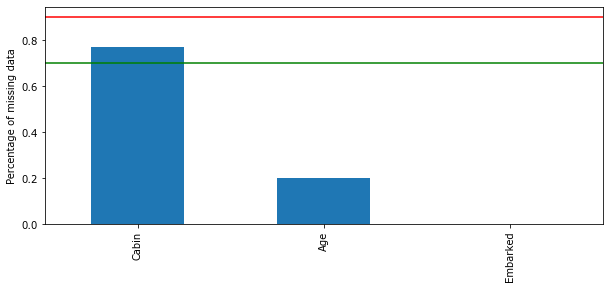

In [38]:
# plot
import matplotlib.pyplot as plt

data[vars_with_na].isnull().mean().sort_values(
    ascending=False).plot.bar(figsize=(10, 4))
plt.ylabel('Percentage of missing data')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.axhline(y=0.70, color='g', linestyle='-')

plt.show()

In [35]:
# first in numerical variables
vars_with_na_numerical = [var for var in vars_num if data[var].isnull().sum() >0]
data[vars_with_na_numerical].isnull().mean().sort_values(ascending=False)

Age    0.198653
dtype: float64

In [37]:
# now in categorical variables

vars_with_na_categorical = [var for var in vars_cat if data[var].isnull().sum() >0]
data[vars_with_na_categorical].isnull().mean().sort_values(ascending=False)

Cabin       0.771044
Embarked    0.002245
dtype: float64

### Determine cardinality of categorical variables

<AxesSubplot:>

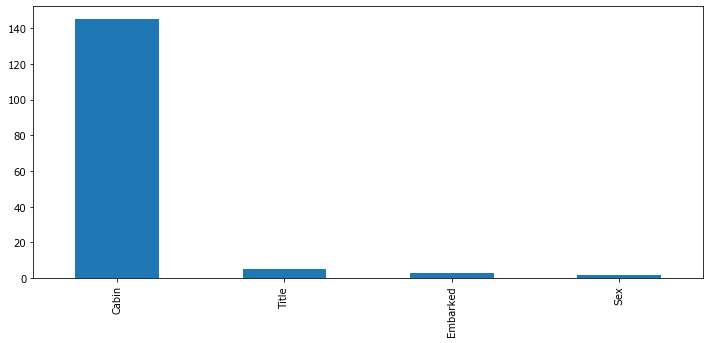

In [50]:
data[vars_cat].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

In [39]:
# now we can determine which variables, from those with missing data,
# are numerical and which are categorical

print('Number of categorical variables with na: ', len(vars_with_na_categorical))
print('Number of numerical variables with na: ', len(vars_with_na_numerical))

Number of categorical variables with na:  2
Number of numerical variables with na:  1


In [40]:
def analyse_na_value(df, var,target=target):

    # copy of the dataframe, so that we do not override the original data
    # see the link for more details about pandas.copy()
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.copy.html
    df = df.copy()

    # let's make an interim variable that indicates 1 if the
    # observation was missing or 0 otherwise
    df[var] = np.where(df[var].isnull(), 1, 0)

    # let's compare the median SalePrice in the observations where data is missing
    # vs the observations where data is available

    # determine the median price in the groups 1 and 0,
    # and the standard deviation of the sale price,
    # and we capture the results in a temporary dataset
    tmp = df.groupby(var)[target].agg(['mean', 'std'])

    # plot into a bar graph
    tmp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title=target, color='green')

    plt.show()

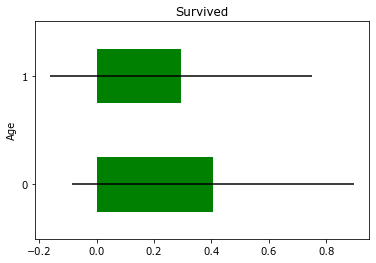

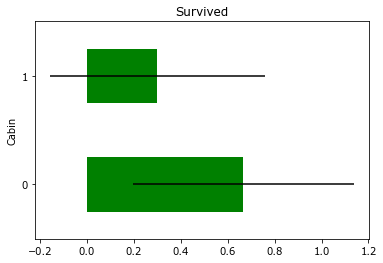

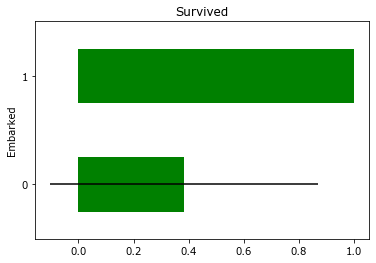

In [41]:
# let's run the function on each variable with missing data

for var in vars_with_na:
    analyse_na_value(data, var)

### Determine the distribution of numerical variables

In [43]:
print(data[vars_num].head())

   PassengerId  Pclass   Age  SibSp  Parch     Fare
0            1       3  22.0      1      0   7.2500
1            2       1  38.0      1      0  71.2833
2            3       3  26.0      0      0   7.9250
3            4       1  35.0      1      0  53.1000
4            5       3  35.0      0      0   8.0500


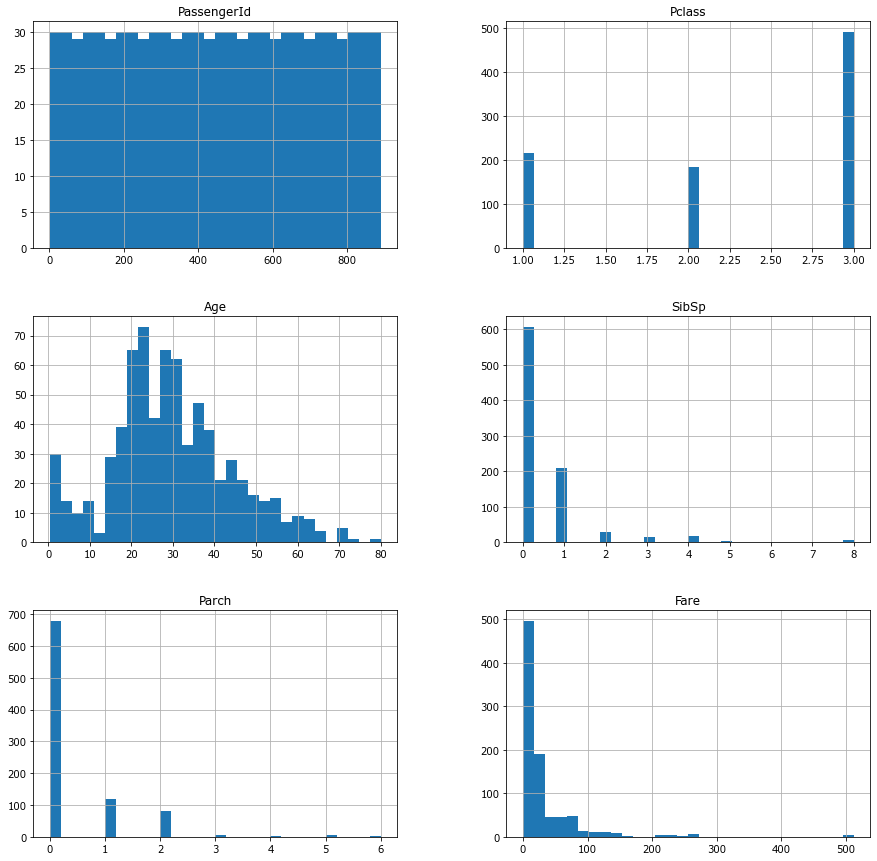

In [49]:
data[vars_num].hist(bins=30, figsize=(15,15))
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [75]:
data['Cabin']=data['Cabin'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Survived', axis=1),  # predictors
    data['Survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility


X_train[vars_cat] = X_train[vars_cat].astype('O')
X_test[vars_cat] = X_test[vars_cat].astype('O')
X_train.shape, X_test.shape

((712, 10), (179, 10))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [76]:
def extract_cabin(cabin):
    if cabin:
        return cabin[0].upper()
    return None

X_train['Cabin']=X_train['Cabin'].apply(lambda x: extract_cabin(x))
X_test['Cabin']=X_test['Cabin'].apply(lambda x: extract_cabin(x))

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [88]:
# replace missing values as we described above

for var in vars_with_na_numerical:

    # calculate the mean using the train set
    mean_val = X_train[var].mean()
    print(var, mean_val)

    # add binary missing indicator (in train and test)
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mean
    # (in train and test)
    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)

# check that we have no more missing values in the engineered variables
X_train[vars_with_na_numerical].isnull().sum()

Age 29.745183887915935


Age         0
Cabin       0
Embarked    0
dtype: int64

In [89]:
[var for var in vars_with_na_numerical if X_test[var].isnull().sum() > 0]

[]

### Replace Missing data in categorical variables with the string **Missing**

In [77]:
# variables to impute with the string missing
with_string_missing = [
    var for var in vars_with_na_categorical if X_train[var].isnull().mean() > 0.1]

# variables to impute with the most frequent category
with_frequent_category = [
    var for var in vars_with_na_categorical if X_train[var].isnull().mean() < 0.1]

In [78]:
X_train[with_string_missing] = X_train[with_string_missing].fillna('Missing')
X_test[with_string_missing] = X_test[with_string_missing].fillna('Missing')

In [85]:
for var in with_frequent_category:
    
    # there can be more than 1 mode in a variable
    # we take the first one with [0]    
    mode = X_train[var].mode()[0]
    
    print(var, mode)
    
    X_train[var].fillna(mode, inplace=True)
    X_test[var].fillna(mode, inplace=True)

Cabin N
Embarked S


In [86]:
# check that we have no missing information in the engineered variables
X_train[vars_with_na_categorical].isnull().sum()

# check that test set does not contain null values in the engineered variables
[var for var in vars_with_na_categorical if X_test[var].isnull().sum() > 0]

Cabin       0
Embarked    0
dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [98]:
categorical_encoded=pd.concat([pd.get_dummies(X_train[col],drop_first=True) for col in ['Sex','Cabin','Embarked','Title']], axis=1)

In [100]:
pd.concat([X_train,categorical_encoded],axis=1)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Age_na,male,B,C,D,E,F,G,N,T,Q,S,Miss,Mr,Mrs,Other
140,141,3,female,29.745184,0,2,15.2458,N,C,Mrs,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
439,440,2,male,31.000000,0,0,10.5000,N,S,Mr,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0
817,818,2,male,31.000000,1,1,37.0042,N,C,Mr,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
378,379,3,male,20.000000,0,0,4.0125,N,C,Mr,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
491,492,3,male,21.000000,0,0,7.2500,N,S,Mr,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,836,1,female,39.000000,1,1,83.1583,E,C,Miss,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
192,193,3,female,19.000000,1,0,7.8542,N,S,Miss,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0
629,630,3,male,29.745184,0,0,7.7333,N,Q,Mr,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0
559,560,3,female,36.000000,1,0,17.4000,N,S,Mrs,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
